# EDA

## Import Libraries

In [28]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers
from sklearn import metrics

## Viewing Images

In this project, we are working with images of chest X-rays which we are classifying into two categories: pneumonia or normal. First, let's look at the difference between these.

#### Normal:
<table style="border-collapse: collapse;">
    <tr>
        <td style="border: none;"><img src="Images/normal1.jpeg" alt="normal1" width="450px"/></td>
        <td style="border: none;"><img src="Images/normal2.jpeg" alt="normal2" width="400px"/></td>
        <td style="border: none;"><img src="Images/normal3.jpeg" alt="normal3" width="400px"/></td>
    </tr>
</table>

#### Pneumonia:
<table style="border-collapse: collapse;">
    <tr>
        <td style="border: none;"><img src="Images/pneumonia1.jpeg" alt="pneumonia1" width="450px"/></td>
        <td style="border: none;"><img src="Images/pneumonia2.jpeg" alt="pneumonia2" width="400px"/></td>
        <td style="border: none;"><img src="Images/pneumonia3.jpeg" alt="pneumonia3" width="400px"/></td>
    </tr>
</table>

From <a href="https://www.radiologyinfo.org/en/info.cfm?pg=pneumonia">Radiology.org</a>: <br> _Pneumonia is an infection that causes inflammation in one or both of the lungs. It can be caused by a virus, bacteria, fungi or other germs. The infection is usually acquired when a person breathes in air carrying germs._

When radiologists look at these images, they look for white spots called infiltrates that identify an infection, as well as abscesses or fluids that could be caused by pneumonia. We find it a bit difficult to tell the difference between these due to not being trained radiologists, but we can definitely say some x-rays (such as the leftmost pneumonia picture above) look more "cloudy" than others.

Further reviewing our data, we can see that:
* Every image is grayscale, only containing color data in the gray channel (as opposed to RGB alpha channels).
* Each image has a different pixel dimension, many with non-square aspect ratios. 
* Most images have tick marks on the left and right edges.
* Many images contain other text near the edges.
* Some images show the patient rotated at an angle.

<img src="Images/tp_512_prob.png" alt="image_problems" width="450px"/>

To remedy any issues caused by this, we will change parameters of ImageDataGenerator while creating our models.

## Class Distribution

Before we start modeling, we want to check for class imbalance. Our data is split into 3 directories, each holding the images needed for our test, train, and validation sets. We'll add up the number of files in these directories to get the count of data points in each class.

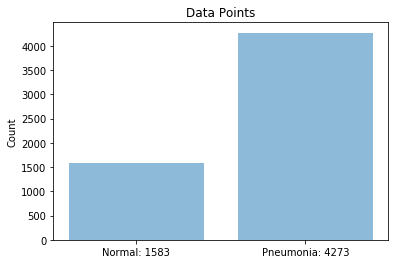

In [2]:
n_count = len(os.listdir('chest_xray/test/NORMAL')) + len(os.listdir('chest_xray/train/NORMAL')) + len(os.listdir('chest_xray/val/NORMAL'))
p_count = len(os.listdir('chest_xray/test/PNEUMONIA')) + len(os.listdir('chest_xray/train/PNEUMONIA')) + len(os.listdir('chest_xray/val/PNEUMONIA'))

objects = (f'Normal: {n_count}', f'Pneumonia: {p_count}')
y_pos = np.arange(len(objects))

plt.bar(y_pos, [n_count,p_count], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Data Points')

plt.show()

We can see we have a 27:73 split. This isn't a huge imbalance, but definitely something to keep in mind when evaluating our models, as our null accuracy is 73%. This is the accuracy we could achieve by always predicting the most frequent class.

# Modeling

## Gather Image Data

First, we get the image data from our folders.

In [6]:
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('chest_xray/train/', target_size=(64, 64), batch_size = 5218)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('chest_xray/test/', target_size=(64, 64), batch_size = 624)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory('chest_xray/val/', target_size=(64, 64), batch_size = 18)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Next, we'll make a list of matrices per image from this data.

In [7]:
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

In [27]:
class_labels = list(train_generator.class_indices.keys())

In [8]:
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

train_images shape: (5216, 64, 64, 3)
train_labels shape: (5216, 2)
test_images shape: (624, 64, 64, 3)
test_labels shape: (624, 2)
val_images shape: (16, 64, 64, 3)
val_labels shape: (16, 2)


In [17]:
train_labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

Our label arrays have 2 columns, one for True and one for False. We only need one of these as having two is redundant.

In [18]:
train_y = np.reshape(train_labels[:,0], (5216,1))
test_y = np.reshape(test_labels[:,0], (624,1))
val_y = np.reshape(val_labels[:,0], (16,1))

## Baseline Model

In [14]:
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(32, (4, 4), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(64, activation='relu'))
model_1.add(layers.Dense(1, activation='sigmoid'))

model_1.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['acc'])

In [19]:
%%time
history_1 = model_1.fit(train_images,
                    train_y,
                    epochs=30,
                    batch_size=50,
                    validation_data=(val_images, val_y))

Train on 5216 samples, validate on 16 samples
Epoch 1/30
5216/5216 [==============================] - 9s 2ms/step - loss: 0.5675 - acc: 0.7429 - val_loss: 0.9412 - val_acc: 0.5000
Epoch 2/30
5216/5216 [==============================] - 10s 2ms/step - loss: 0.5255 - acc: 0.7454 - val_loss: 0.7597 - val_acc: 0.5000
Epoch 3/30
5216/5216 [==============================] - 9s 2ms/step - loss: 0.4708 - acc: 0.7795 - val_loss: 1.0091 - val_acc: 0.5625
Epoch 4/30
5216/5216 [==============================] - 10s 2ms/step - loss: 0.3971 - acc: 0.8234 - val_loss: 0.6720 - val_acc: 0.6250
Epoch 5/30
5216/5216 [==============================] - 10s 2ms/step - loss: 0.3352 - acc: 0.8608 - val_loss: 0.7418 - val_acc: 0.6250
Epoch 6/30
5216/5216 [==============================] - 10s 2ms/step - loss: 0.2493 - acc: 0.8974 - val_loss: 0.8306 - val_acc: 0.6250
Epoch 7/30
5216/5216 [==============================] - 10s 2ms/step - loss: 0.2152 - acc: 0.9132 - val_loss: 0.7312 - val_acc: 0.5625
Epoch 8/30


## Evaluating Model

In [33]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model_1.predict_generator(test_generator, steps=test_steps_per_epoch)
predicted_classes = np.argmax(predictions, axis=1)

In [36]:
predicted_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
results_test_1 = model_1.evaluate(test_images, test_y)
print(model_1.metrics_names, results_test_1)

624/624 [==============================] - 0s 362us/step
['loss', 'acc'] [0.9883719927225357, 0.7275640964508057]


In [40]:
report = metrics.classification_report(test_y, predicted_classes, target_names=class_labels)
print(report)    

              precision    recall  f1-score   support

      NORMAL       0.62      1.00      0.77       390
   PNEUMONIA       0.00      0.00      0.00       234

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/Users/GabbaFlabba/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [43]:
confusion_matrix = metrics.confusion_matrix(test_y, predicted_classes)
print(confusion_matrix)    

[[390   0]
 [234   0]]


In [ ]:
def evaluate_test(model, test_X, test_y):
    results = model.evaluate(test_X, test_y)
    print('Loss:', results[0])
    print('Accuracy:', results[1])